In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Equation: 

# $$ \frac{dx}{dt} = \lambda x$$

# == Setup ==



# Generator (regression):

<img src="generator.png" width="500">

# Discriminator (classification):

<img src="discriminator.png" width="500">

## Analytical Solutionn

In [2]:
L = -1
analytic = lambda t: np.exp(L*t)

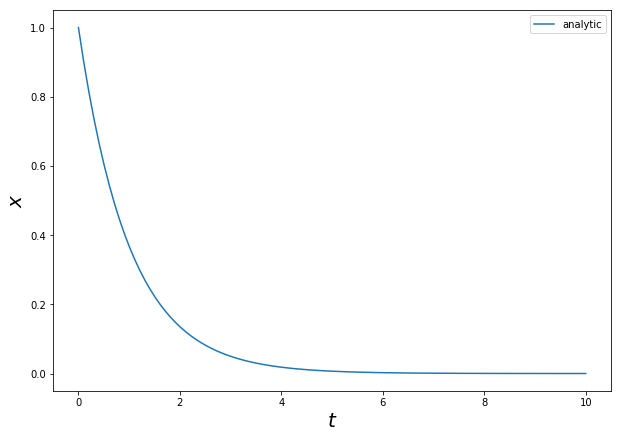

In [3]:
t = np.linspace(0,10,100)
plt.figure(figsize=(10,7))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.plot(t, analytic(t), '-', label='analytic')
plt.legend();

## GAN

In [4]:
import torch
import torch.nn as nn
from torch import tensor, autograd

In [19]:
class Generator(nn.Module):
    def __init__(self, n_hidden=20):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1) # regression
        )
    
    def forward(self, x):
        output = self.main(x)
        return output

class Discriminator(nn.Module):
    def __init__(self, n_hidden=20):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1),
            nn.Sigmoid() # classification
        )
    
    def forward(self, x):
        output = self.main(x)
        return output

In [20]:
G = Generator()
D = Discriminator()

In [21]:
t = tensor(t, dtype=torch.float, requires_grad=True).reshape(-1,1)

In [22]:
real_label = 1
fake_label = 0
criterion = nn.BCELoss()

In [23]:
# setup optimizer
optimizerD = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.9, 0.999))

In [38]:
def train(G, D, t, optiG, optiD, criterion, epochs, real_label=1, fake_label=0):
    D_losses = []
    G_losses = []
    Dx_list = []
    DGz1_list = []
    DGz2_list = []
    
    for epoch in range(epochs):

        # generate x
        real = G(t)

        # compute dx/dt
        fake, = autograd.grad(real, t, grad_outputs=real.data.new(real.shape).fill_(1),
                               retain_graph=True, create_graph=True)
        
        ## ========
        ## UPDATE D
        ## ========
        
        # train with real
        D.zero_grad()
        label = torch.full((t.shape[0],), real_label).reshape(-1,1)
        output = D(real)
        errD_real = criterion(output, label)
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item() # for logging
        
        # train with fake
        label.fill_(fake_label)
        output = D(fake)
        errD_fake = criterion(output, label)
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        
        # step for D
        errD = errD_real + errD_fake # for logging
        optiD.step()
        
        ## ========
        ## UPDATE G
        ## ========
        
        G.zero_grad()
        label.fill_(real_label) # fake labels == real for Generator
        output = D(fake)
        errG = criterion(output, label)
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item() # for logging
        optiG.step()
        
        ## ========
        ## Logging
        ## ======== 
        print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, epochs,
                     errD.item(), errG.item(), 
                     D_x, D_G_z1, D_G_z2))
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        Dx_list.append(D_x)
        DGz1_list.append(D_G_z1)
        DGz2_list.append(D_G_z2)
        
    return G, D, G_losses, D_losses, Dx_list, DGz1_list, DGz2_list

In [39]:
G,D,G_loss,D_loss,Dx_vals,DGz1_vals,DGz2_vals = train(G, D, t, optimizerG, optimizerD, criterion, 1000)

[0/1000] Loss_D: 0.4016 Loss_G: 2.5939 D(x): 0.8772 D(G(z)): 0.1231 / 0.1229
[1/1000] Loss_D: 0.3989 Loss_G: 2.5974 D(x): 0.8778 D(G(z)): 0.1227 / 0.1225
[2/1000] Loss_D: 0.3961 Loss_G: 2.6015 D(x): 0.8785 D(G(z)): 0.1223 / 0.1221
[3/1000] Loss_D: 0.3930 Loss_G: 2.6062 D(x): 0.8792 D(G(z)): 0.1219 / 0.1216
[4/1000] Loss_D: 0.3898 Loss_G: 2.6115 D(x): 0.8800 D(G(z)): 0.1215 / 0.1212
[5/1000] Loss_D: 0.3870 Loss_G: 2.6175 D(x): 0.8802 D(G(z)): 0.1211 / 0.1207
[6/1000] Loss_D: 0.3972 Loss_G: 2.6221 D(x): 0.8742 D(G(z)): 0.1206 / 0.1203
[7/1000] Loss_D: 0.4098 Loss_G: 2.6249 D(x): 0.8734 D(G(z)): 0.1202 / 0.1201
[8/1000] Loss_D: 0.4092 Loss_G: 2.6261 D(x): 0.8744 D(G(z)): 0.1200 / 0.1200
[9/1000] Loss_D: 0.4048 Loss_G: 2.6262 D(x): 0.8756 D(G(z)): 0.1200 / 0.1200
[10/1000] Loss_D: 0.3998 Loss_G: 2.6258 D(x): 0.8770 D(G(z)): 0.1200 / 0.1200
[11/1000] Loss_D: 0.3946 Loss_G: 2.6254 D(x): 0.8784 D(G(z)): 0.1200 / 0.1201
[12/1000] Loss_D: 0.3890 Loss_G: 2.6255 D(x): 0.8799 D(G(z)): 0.1201 / 0.1

[194/1000] Loss_D: 0.5256 Loss_G: 2.2347 D(x): 0.8513 D(G(z)): 0.1690 / 0.1599
[195/1000] Loss_D: 0.5165 Loss_G: 2.2969 D(x): 0.8525 D(G(z)): 0.1606 / 0.1525
[196/1000] Loss_D: 0.5053 Loss_G: 2.3555 D(x): 0.8554 D(G(z)): 0.1532 / 0.1456
[197/1000] Loss_D: 0.4946 Loss_G: 2.4090 D(x): 0.8574 D(G(z)): 0.1461 / 0.1391
[198/1000] Loss_D: 0.4848 Loss_G: 2.4540 D(x): 0.8582 D(G(z)): 0.1395 / 0.1339
[199/1000] Loss_D: 0.4759 Loss_G: 2.4880 D(x): 0.8590 D(G(z)): 0.1341 / 0.1302
[200/1000] Loss_D: 0.4679 Loss_G: 2.5115 D(x): 0.8607 D(G(z)): 0.1302 / 0.1280
[201/1000] Loss_D: 0.4609 Loss_G: 2.5269 D(x): 0.8629 D(G(z)): 0.1279 / 0.1267
[202/1000] Loss_D: 0.4549 Loss_G: 2.5366 D(x): 0.8649 D(G(z)): 0.1266 / 0.1260
[203/1000] Loss_D: 0.4499 Loss_G: 2.5416 D(x): 0.8662 D(G(z)): 0.1258 / 0.1255
[204/1000] Loss_D: 0.4459 Loss_G: 2.5420 D(x): 0.8668 D(G(z)): 0.1252 / 0.1254
[205/1000] Loss_D: 0.4429 Loss_G: 2.5374 D(x): 0.8671 D(G(z)): 0.1252 / 0.1261
[206/1000] Loss_D: 0.4409 Loss_G: 2.5285 D(x): 0.867

[393/1000] Loss_D: 0.3791 Loss_G: 2.5950 D(x): 0.8853 D(G(z)): 0.1178 / 0.1174
[394/1000] Loss_D: 0.3879 Loss_G: 2.6015 D(x): 0.8835 D(G(z)): 0.1176 / 0.1173
[395/1000] Loss_D: 0.3981 Loss_G: 2.6068 D(x): 0.8818 D(G(z)): 0.1174 / 0.1172
[396/1000] Loss_D: 0.3774 Loss_G: 2.6116 D(x): 0.8827 D(G(z)): 0.1173 / 0.1170
[397/1000] Loss_D: 0.3705 Loss_G: 2.6176 D(x): 0.8881 D(G(z)): 0.1170 / 0.1166
[398/1000] Loss_D: 0.3773 Loss_G: 2.6238 D(x): 0.8862 D(G(z)): 0.1167 / 0.1163
[399/1000] Loss_D: 0.3866 Loss_G: 2.6290 D(x): 0.8842 D(G(z)): 0.1163 / 0.1162
[400/1000] Loss_D: 0.3977 Loss_G: 2.6326 D(x): 0.8823 D(G(z)): 0.1161 / 0.1161
[401/1000] Loss_D: 0.3711 Loss_G: 2.6359 D(x): 0.8853 D(G(z)): 0.1160 / 0.1160
[402/1000] Loss_D: 0.3706 Loss_G: 2.6402 D(x): 0.8886 D(G(z)): 0.1159 / 0.1158
[403/1000] Loss_D: 0.3785 Loss_G: 2.6448 D(x): 0.8867 D(G(z)): 0.1157 / 0.1155
[404/1000] Loss_D: 0.3901 Loss_G: 2.6485 D(x): 0.8846 D(G(z)): 0.1154 / 0.1152
[405/1000] Loss_D: 0.3940 Loss_G: 2.6506 D(x): 0.882

[559/1000] Loss_D: 0.3922 Loss_G: 2.6547 D(x): 0.8816 D(G(z)): 0.1157 / 0.1155
[560/1000] Loss_D: 0.3846 Loss_G: 2.6519 D(x): 0.8837 D(G(z)): 0.1160 / 0.1158
[561/1000] Loss_D: 0.3767 Loss_G: 2.6497 D(x): 0.8856 D(G(z)): 0.1164 / 0.1161
[562/1000] Loss_D: 0.4018 Loss_G: 2.6460 D(x): 0.8786 D(G(z)): 0.1167 / 0.1165
[563/1000] Loss_D: 0.3923 Loss_G: 2.6421 D(x): 0.8813 D(G(z)): 0.1172 / 0.1169
[564/1000] Loss_D: 0.3823 Loss_G: 2.6390 D(x): 0.8841 D(G(z)): 0.1177 / 0.1173
[565/1000] Loss_D: 0.4053 Loss_G: 2.6345 D(x): 0.8773 D(G(z)): 0.1181 / 0.1178
[566/1000] Loss_D: 0.3944 Loss_G: 2.6299 D(x): 0.8804 D(G(z)): 0.1187 / 0.1183
[567/1000] Loss_D: 0.3829 Loss_G: 2.6264 D(x): 0.8833 D(G(z)): 0.1192 / 0.1187
[568/1000] Loss_D: 0.4043 Loss_G: 2.6222 D(x): 0.8774 D(G(z)): 0.1197 / 0.1192
[569/1000] Loss_D: 0.3914 Loss_G: 2.6186 D(x): 0.8809 D(G(z)): 0.1203 / 0.1197
[570/1000] Loss_D: 0.4122 Loss_G: 2.6138 D(x): 0.8747 D(G(z)): 0.1208 / 0.1203
[571/1000] Loss_D: 0.3989 Loss_G: 2.6092 D(x): 0.878

[748/1000] Loss_D: 0.3775 Loss_G: 2.6502 D(x): 0.8877 D(G(z)): 0.1131 / 0.1133
[749/1000] Loss_D: 0.3789 Loss_G: 2.6491 D(x): 0.8874 D(G(z)): 0.1129 / 0.1130
[750/1000] Loss_D: 0.3807 Loss_G: 2.6479 D(x): 0.8871 D(G(z)): 0.1126 / 0.1128
[751/1000] Loss_D: 0.3829 Loss_G: 2.6464 D(x): 0.8868 D(G(z)): 0.1124 / 0.1125
[752/1000] Loss_D: 0.3856 Loss_G: 2.6443 D(x): 0.8863 D(G(z)): 0.1121 / 0.1123
[753/1000] Loss_D: 0.3888 Loss_G: 2.6414 D(x): 0.8858 D(G(z)): 0.1119 / 0.1122
[754/1000] Loss_D: 0.3924 Loss_G: 2.6378 D(x): 0.8854 D(G(z)): 0.1118 / 0.1122
[755/1000] Loss_D: 0.3955 Loss_G: 2.6338 D(x): 0.8848 D(G(z)): 0.1118 / 0.1121
[756/1000] Loss_D: 0.3963 Loss_G: 2.6294 D(x): 0.8843 D(G(z)): 0.1117 / 0.1121
[757/1000] Loss_D: 0.3891 Loss_G: 2.6246 D(x): 0.8838 D(G(z)): 0.1117 / 0.1122
[758/1000] Loss_D: 0.3681 Loss_G: 2.6208 D(x): 0.8860 D(G(z)): 0.1118 / 0.1121
[759/1000] Loss_D: 0.3598 Loss_G: 2.6192 D(x): 0.8916 D(G(z)): 0.1117 / 0.1119
[760/1000] Loss_D: 0.3621 Loss_G: 2.6195 D(x): 0.891

[928/1000] Loss_D: 0.4267 Loss_G: 2.8285 D(x): 0.8764 D(G(z)): 0.1124 / 0.1106
[929/1000] Loss_D: 0.3936 Loss_G: 2.8258 D(x): 0.8822 D(G(z)): 0.1099 / 0.1086
[930/1000] Loss_D: 0.4177 Loss_G: 2.8131 D(x): 0.8775 D(G(z)): 0.1083 / 0.1079
[931/1000] Loss_D: 0.3908 Loss_G: 2.7959 D(x): 0.8829 D(G(z)): 0.1079 / 0.1076
[932/1000] Loss_D: 0.4145 Loss_G: 2.7673 D(x): 0.8771 D(G(z)): 0.1080 / 0.1092
[933/1000] Loss_D: 0.3925 Loss_G: 2.7362 D(x): 0.8822 D(G(z)): 0.1098 / 0.1107
[934/1000] Loss_D: 0.4187 Loss_G: 2.6945 D(x): 0.8757 D(G(z)): 0.1115 / 0.1141
[935/1000] Loss_D: 0.3977 Loss_G: 2.6528 D(x): 0.8806 D(G(z)): 0.1150 / 0.1172
[936/1000] Loss_D: 0.4297 Loss_G: 2.6042 D(x): 0.8738 D(G(z)): 0.1182 / 0.1217
[937/1000] Loss_D: 0.4058 Loss_G: 2.5569 D(x): 0.8783 D(G(z)): 0.1225 / 0.1259
[938/1000] Loss_D: 0.4181 Loss_G: 2.5099 D(x): 0.8728 D(G(z)): 0.1267 / 0.1302
[939/1000] Loss_D: 0.4181 Loss_G: 2.4644 D(x): 0.8754 D(G(z)): 0.1308 / 0.1346
[940/1000] Loss_D: 0.4062 Loss_G: 2.4267 D(x): 0.879

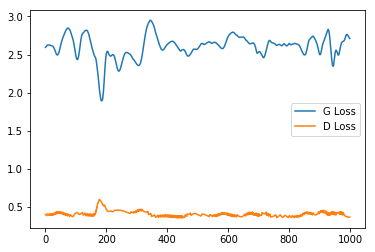

In [42]:
epochs=np.arange(len(G_loss))
plt.plot(epochs, G_loss, label='G Loss')
plt.plot(epochs, D_loss, label='D Loss')
plt.legend();